In [1]:
import IPython
clear_dis = IPython.display.clear_output

In [2]:
# model
import xgboost as xgb
import catboost as ctb
import lightgbm as lgbm

# model helper
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, cross_val_score,train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,f1_score,log_loss
from sklearn.manifold import TSNE

# Utilities
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster,linkage,dendrogram
from scipy.spatial.distance import pdist, squareform

# Import the data

In [3]:
original_train_df = pd.read_csv('../input/vector-borne-disease-prediction/trainn.csv')
original_test_df = pd.read_csv('../input/vector-borne-disease-prediction/testt.csv')

In [4]:
syn_train_df = pd.read_csv('../input/playground-series-s3e13/train.csv')
syn_test_df = pd.read_csv('../input/playground-series-s3e13/test.csv')

In [5]:
original_train_df['prognosis'] = original_train_df['prognosis'].apply(lambda x: x.replace(' ','_'))
original_test_df['prognosis'] = original_test_df['prognosis'].apply(lambda x: x.replace(' ','_'))

In [6]:
train_df = pd.concat([original_train_df,original_test_df,syn_train_df]).reset_index(drop = True)
train_df = train_df.drop(columns = 'id')

In [7]:
train_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chikungunya
1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chikungunya
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chikungunya
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chikungunya
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chikungunya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Plague
966,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Malaria
967,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
968,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Plague


# EDA

## Symtoms associate with all Diseases

In [8]:
## This is a basic observation of how often that they say "YES(1)" in each prognosis (target)
symacd = train_df.groupby('prognosis').mean()
symacd_sum = symacd.sum().sort_values(ascending = False)
symacd = symacd[symacd_sum.index]
symacd

,muscle_pain,sudden_fever,nose_bleed,rash,light_sensitivity,yellow_skin,mouth_bleed,joint_pain,loss_of_appetite,abdominal_pain,...,stiff_neck,itchiness,toenail_loss,ulcers,toe_inflammation,lips_irritation,finger_inflammation,breathing_restriction,speech_problem,bullseye_rash
prognosis,,,,,,,,,,,,,,,,,,,,,
Chikungunya,0.600000,0.611111,0.688889,0.666667,0.044444,0.055556,0.511111,0.600000,0.044444,0.044444,...,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dengue,0.574713,0.517241,0.620690,0.551724,0.160920,0.149425,0.563218,0.597701,0.183908,0.195402,...,0.103448,0.264368,0.195402,0.252874,0.126437,0.091954,0.057471,0.045977,0.068966,0.080460
Japanese_encephalitis,0.495238,0.504762,0.457143,0.371429,0.580952,0.619048,0.419048,0.400000,0.447619,0.495238,...,0.228571,0.076190,0.057143,0.076190,0.038095,0.057143,0.038095,0.028571,0.000000,0.000000
Lyme_disease,0.546667,0.693333,0.693333,0.560000,0.666667,0.706667,0.693333,0.666667,0.693333,0.640000,...,0.480000,0.346667,0.280000,0.173333,0.506667,0.440000,0.440000,0.413333,0.426667,0.426667
Malaria,0.611111,0.666667,0.638889,0.708333,0.666667,0.722222,0.527778,0.652778,0.611111,0.708333,...,0.097222,0.000000,0.000000,0.000000,0.055556,0.055556,0.055556,0.055556,0.000000,0.000000
Plague,0.623377,0.597403,0.506494,0.545455,0.779221,0.740260,0.519481,0.467532,0.701299,0.701299,...,0.311688,0.012987,0.012987,0.012987,0.389610,0.389610,0.376623,0.376623,0.025974,0.012987
Rift_Valley_fever,0.404255,0.489362,0.446809,0.489362,0.351064,0.244681,0.553191,0.446809,0.244681,0.244681,...,0.085106,0.265957,0.159574,0.223404,0.127660,0.106383,0.053191,0.042553,0.085106,0.095745
Tungiasis,0.276596,0.191489,0.180851,0.265957,0.180851,0.223404,0.212766,0.265957,0.265957,0.159574,...,0.031915,0.712766,0.744681,0.712766,0.053191,0.053191,0.085106,0.095745,0.021277,0.010638
West_Nile_fever,0.596330,0.504587,0.596330,0.431193,0.550459,0.495413,0.522936,0.403670,0.431193,0.458716,...,0.321101,0.082569,0.091743,0.082569,0.110092,0.073394,0.091743,0.082569,0.018349,0.018349


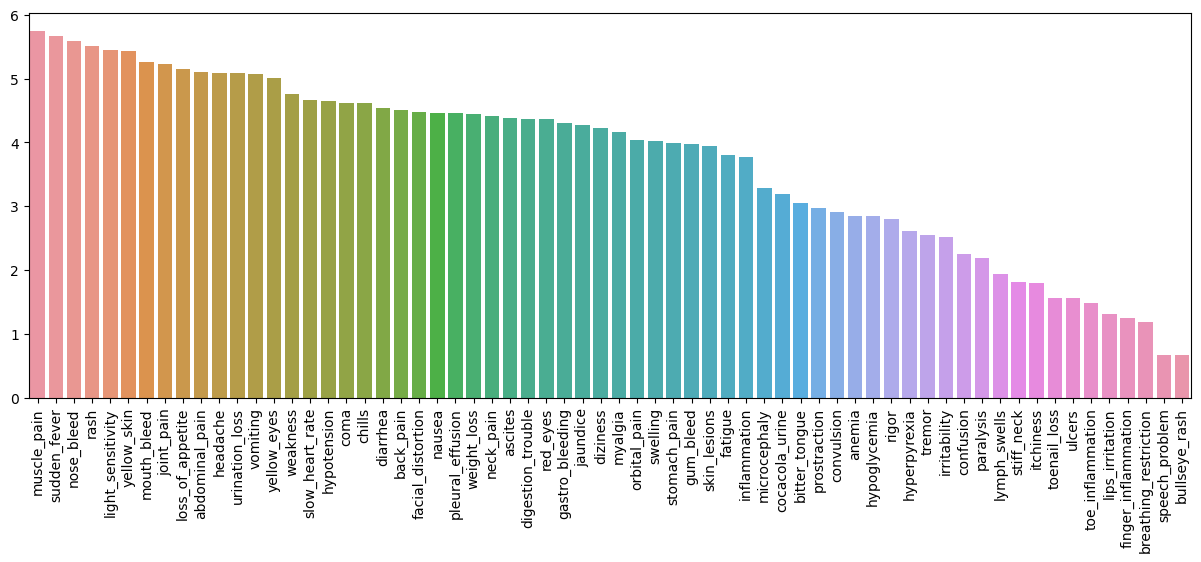

In [9]:
fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(x = symacd_sum.index, y = symacd_sum, ax = ax,)
ax.tick_params( axis = 'x', rotation = 90, labelsize = 10 )

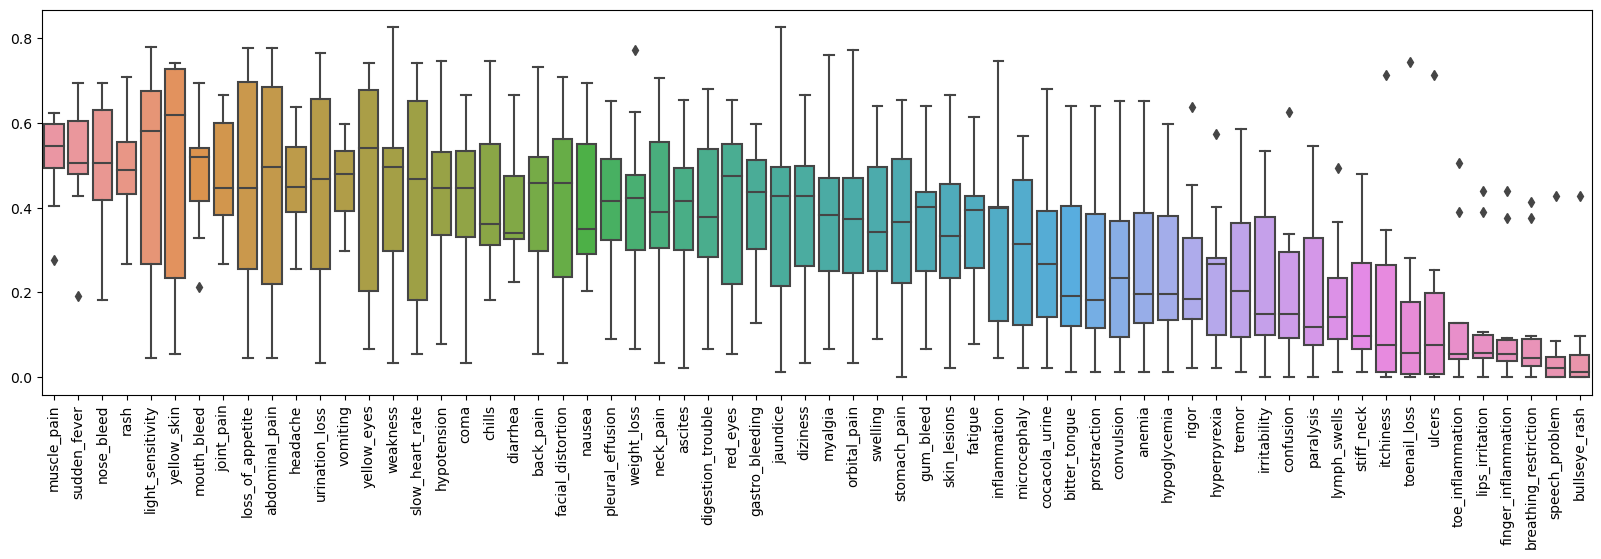

In [10]:
fig,ax = plt.subplots(figsize = (20,5))
sns.boxplot(symacd,ax = ax)
ax.tick_params( axis = 'x', rotation = 90, labelsize = 10 )

## Symtoms asscociation Similarity

<AxesSubplot:ylabel='prognosis'>

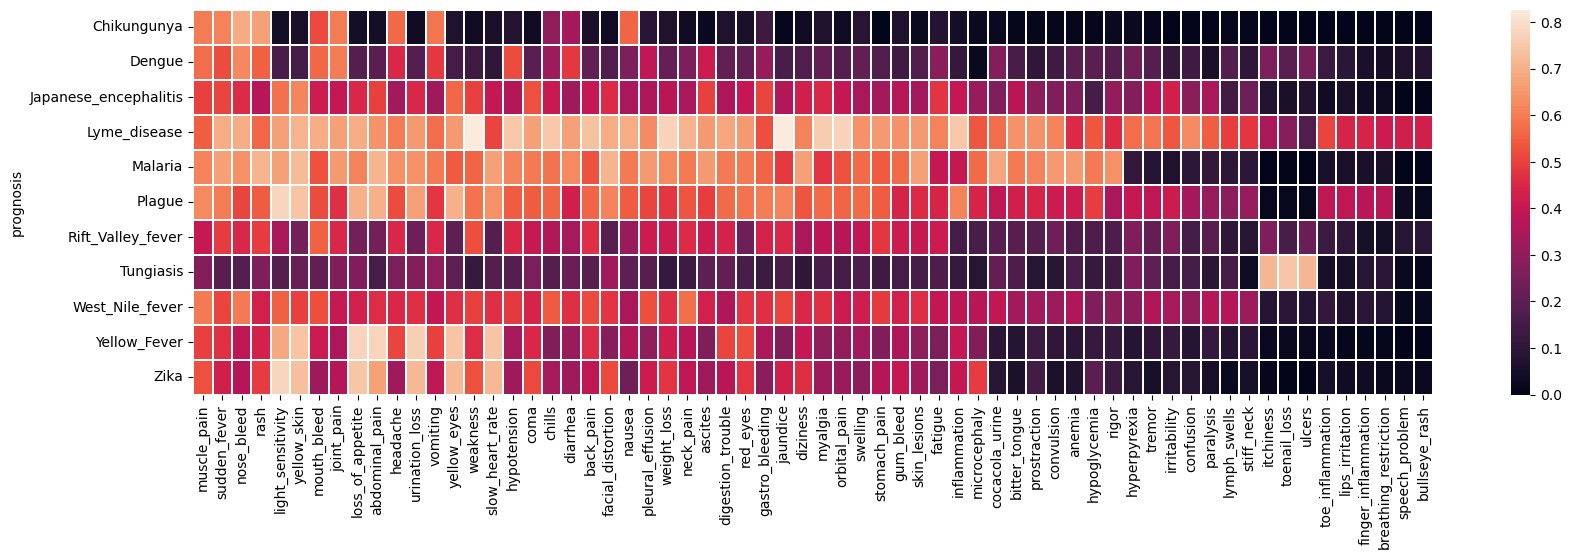

In [11]:
fig,ax = plt.subplots(figsize = (20,5))
sns.heatmap(symacd,\
            linewidths = 0.005,ax = ax)


In [12]:
print(f'------ 4 lowest rank of association ------')
lowest_rank = symacd_sum.sort_values()[:4].index.tolist()
for i in lowest_rank: print(i)

------ 4 lowest rank of association ------
bullseye_rash
speech_problem
breathing_restriction
finger_inflammation


# Feature Engineering

In [13]:
class DataAug:
    def __init__(self,features,target = None):
        self.features = features
        self.target = target
        self.result_df = dict()
    
    def get_aug(self,comp):
#         self.tsne(comp)
        self.asso_score()
        self.clustering()
        aug_df = pd.concat(
            [x for x in self.result_df.values()],axis = 1
        )
        aug_df = pd.concat([self.features,self.target,aug_df],axis = 1)
        return aug_df
        
    
    def tsne(self,comp):
        col_comp = [f't{x}' for x in range(comp)]
        comp = TSNE(n_components = comp,random_state = 0,method = 'exact')
        embedd = comp.fit_transform(self.features)
        self.result_df['tsne'] = pd.DataFrame(embedd,columns = col_comp, index = self.features.index)
    
    def asso_score(self):
        asso_score = list()
        for i,r in enumerate(self.features.iterrows()):
            s = sum(r[1].tolist())
            asso_score.append(s)
        asso_score = pd.DataFrame(np.array(asso_score),columns = ['asso_score'])
        self.result_df['asso_score'] = asso_score
    
    def clustering(self):
        clust_df = {}
        clust_dict = {'C1': ['itchiness',
                          'ulcers',
                          'toenail_loss',
                          'rigor',
                          'anemia',
                          'hypoglycemia',
                          'convulsion',
                          'prostraction',
                          'bitter_tongue',
                          'cocacola_urine',
                          'speech_problem',
                          'bullseye_rash',
                          'toe_inflammation',
                          'lips_irritation',
                          'breathing_restriction',
                          'finger_inflammation',
                          'hyperpyrexia',
                          'irritability',
                          'tremor',
                          'lymph_swells',
                          'confusion',
                          'stiff_neck',
                          'paralysis'],
                         'C2': ['rash',
                          'headache',
                          'vomiting',
                          'sudden_fever',
                          'muscle_pain',
                          'joint_pain',
                          'mouth_bleed',
                          'nose_bleed'],
                         'C3': ['light_sensitivity',
                          'yellow_eyes',
                          'loss_of_appetite',
                          'yellow_skin',
                          'urination_loss',
                          'slow_heart_rate',
                          'abdominal_pain',
                          'pleural_effusion',
                          'hypotension',
                          'ascites',
                          'diarrhea',
                          'nausea',
                          'facial_distortion',
                          'microcephaly',
                          'inflammation',
                          'red_eyes',
                          'digestion_trouble',
                          'coma',
                          'back_pain',
                          'weight_loss',
                          'swelling',
                          'skin_lesions',
                          'diziness',
                          'weakness',
                          'gum_bleed',
                          'myalgia',
                          'orbital_pain',
                          'jaundice',
                          'stomach_pain',
                          'neck_pain',
                          'chills',
                          'gastro_bleeding',
                          'fatigue'],
                          'lyme_col':['jaundice', 'weight_loss', 'weakness', 'back_pain', 'sudden_fever', 'myalgia', 'chills', 'orbital_pain', 'digestion_trouble'],
                        'pain_clust' : self.features.columns[self.features.columns.str.contains('pain')],
                        'inflammation_clust' : self.features.columns[self.features.columns.str.contains('inflammation')],
                        'bleeding_clust' : self.features.columns[self.features.columns.str.contains('bleed')],
                        'skin_clust' : self.features.columns[self.features.columns.str.contains('bleed')].tolist() + ['itchiness'],
                     }
        for k , v in clust_dict.items():
            clust_df[k] = self.features[v].sum(axis = 1)
        self.result_df['cluster'] = pd.DataFrame(clust_df)
        

In [14]:
train_aug = DataAug(train_df.drop(columns = 'prognosis'),train_df['prognosis'])
train_df_aug = train_aug.get_aug(2)

In [15]:
test_aug = DataAug(syn_test_df)
test_df_aug = test_aug.get_aug(2)

In [16]:
train_df_aug

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,prognosis,asso_score,C1,C2,C3,lyme_col,pain_clust,inflammation_clust,bleeding_clust,skin_clust
0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Chikungunya,6.0,0.0,5.0,1.0,0.0,1.0,0.0,3.0,3.0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,Chikungunya,9.0,0.0,7.0,2.0,1.0,1.0,0.0,2.0,2.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,Chikungunya,5.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,Chikungunya,4.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,Chikungunya,6.0,0.0,5.0,1.0,2.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Plague,20.0,0.0,3.0,17.0,4.0,3.0,1.0,3.0,3.0
966,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,Malaria,19.0,0.0,6.0,13.0,1.0,3.0,1.0,2.0,2.0
967,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,Zika,29.0,5.0,4.0,20.0,6.0,2.0,0.0,1.0,1.0
968,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,Plague,41.0,13.0,4.0,24.0,8.0,5.0,2.0,1.0,1.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


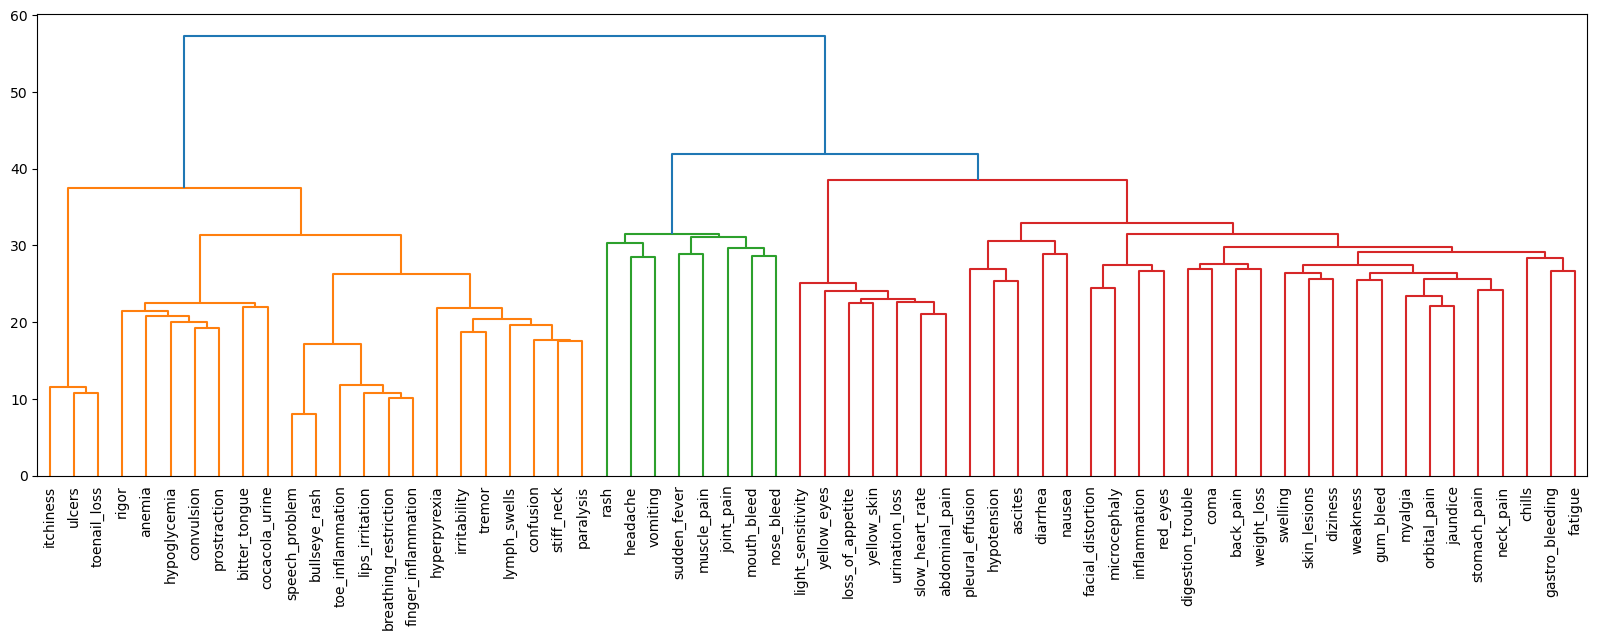

In [17]:
feats = train_df.drop(columns = 'prognosis').T
feats_label = train_df.columns.to_list()[:-1]
linkage_mtx = linkage(squareform(pdist(feats)),method = 'complete')
fig,ax = plt.subplots(figsize=(20,6))
p = dendrogram(linkage_mtx,labels=feats_label)
ax.tick_params( axis = 'x',labelsize = 10 )
plt.show()

In [18]:
cluster = {}
for k,v in zip(p['leaves_color_list'],p['ivl']):
    if k not in cluster:
        cluster[k] = [v]
    else:
        cluster[k].append(v)
cluster

{'C1': ['itchiness',
  'ulcers',
  'toenail_loss',
  'rigor',
  'anemia',
  'hypoglycemia',
  'convulsion',
  'prostraction',
  'bitter_tongue',
  'cocacola_urine',
  'speech_problem',
  'bullseye_rash',
  'toe_inflammation',
  'lips_irritation',
  'breathing_restriction',
  'finger_inflammation',
  'hyperpyrexia',
  'irritability',
  'tremor',
  'lymph_swells',
  'confusion',
  'stiff_neck',
  'paralysis'],
 'C2': ['rash',
  'headache',
  'vomiting',
  'sudden_fever',
  'muscle_pain',
  'joint_pain',
  'mouth_bleed',
  'nose_bleed'],
 'C3': ['light_sensitivity',
  'yellow_eyes',
  'loss_of_appetite',
  'yellow_skin',
  'urination_loss',
  'slow_heart_rate',
  'abdominal_pain',
  'pleural_effusion',
  'hypotension',
  'ascites',
  'diarrhea',
  'nausea',
  'facial_distortion',
  'microcephaly',
  'inflammation',
  'red_eyes',
  'digestion_trouble',
  'coma',
  'back_pain',
  'weight_loss',
  'swelling',
  'skin_lesions',
  'diziness',
  'weakness',
  'gum_bleed',
  'myalgia',
  'orbita

# t-SNE

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='t0', ylabel='t1'>

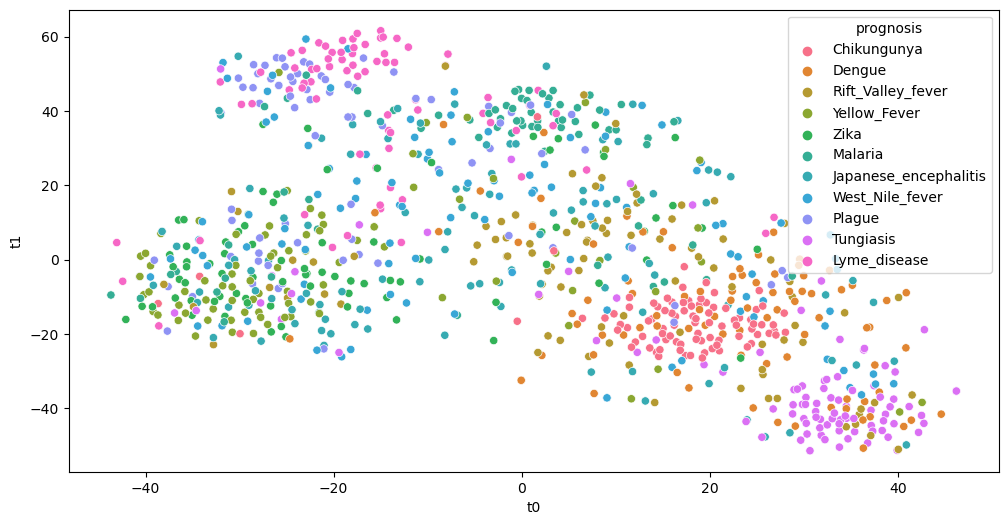

In [19]:
tsne_plot = DataAug(train_df.drop(columns = 'prognosis'),train_df['prognosis'])
tsne_plot.tsne(2)
fig,ax = plt.subplots(figsize = (12,6))
embedd = pd.concat([train_df['prognosis'],tsne_plot.result_df['tsne']],axis = 1)
sns.scatterplot(embedd,x = 't0',y = 't1',hue = 'prognosis',ax = ax,)

# Asso Score

<AxesSubplot:xlabel='asso_score', ylabel='Density'>

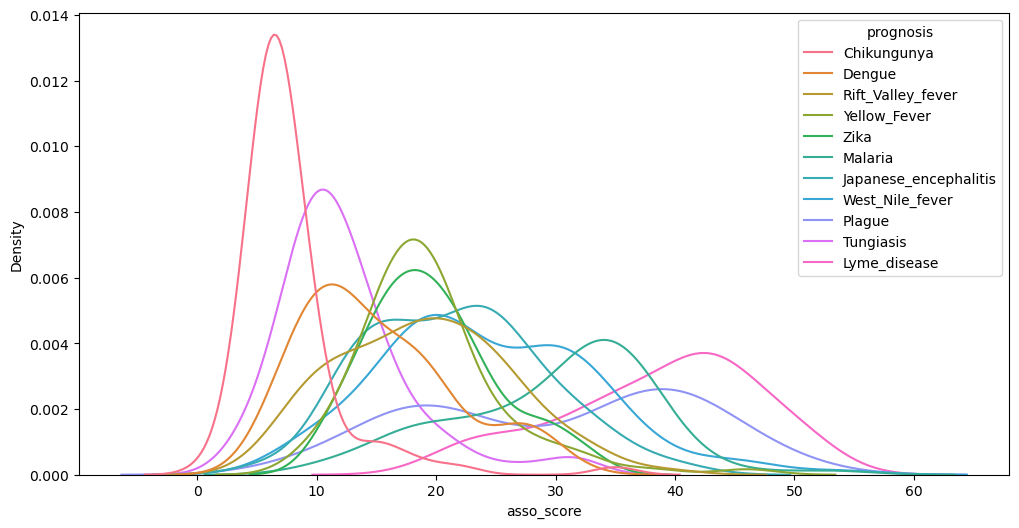

In [20]:
tsne_plot = DataAug(train_df.drop(columns = 'prognosis'),train_df['prognosis'])
tsne_plot.asso_score()
fig,ax = plt.subplots(figsize = (12,6))
asso = pd.concat([train_df['prognosis'],tsne_plot.result_df['asso_score']],axis = 1)
sns.kdeplot(asso,x = 'asso_score',hue = 'prognosis')

## Prepare features and target

In [21]:
train_df_aug = train_df_aug.sample(frac = 1,random_state = 1995).reset_index(drop = True)

In [22]:
le = LabelEncoder()
features = train_df_aug.drop(columns = 'prognosis')
target = le.fit_transform(train_df_aug['prognosis'])

# Modeling

In [23]:
def plot_feature_importance(feat_arr):
    fig,ax = plt.subplots(figsize = (15,12))
    feat_df = pd.Series(feat_arr,index = train_df_aug.drop(columns = 'prognosis').columns).sort_values()
    feat_df.plot(kind = 'barh',ax = ax)

In [24]:
xgb_params = {
        'max_depth': 6,
        'max_bin': 256,
        'subsample': 0.6,
        'n_estimators': 94,
        'learning_rate': 0.1,
        'random_state': 1995,
        'colsample_bytree': 0.1, 
        'objective': 'multi:softprob',
    
}

ctb_params = {
    
}

lgbm_params = {
    
}

In [25]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**xgb_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=94, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, random_state=1995, reg_alpha=None, ...)

In [26]:
xgb_model.__dict__

{'use_label_encoder': False,
 'n_estimators': 94,
 'objective': 'multi:softprob',
 'max_depth': 6,
 'max_leaves': None,
 'max_bin': 256,
 'grow_policy': None,
 'learning_rate': 0.1,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': None,
 'min_child_weight': None,
 'max_delta_step': None,
 'subsample': 0.6,
 'sampling_method': None,
 'colsample_bytree': 0.1,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'random_state': 1995,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': None,
 'gpu_id': None,
 'validate_parameters': None,
 'predictor': None,
 'enable_categorical': False,
 'max_cat_to_onehot': None,
 'eval_metric': None,
 'early_stopping_rounds': None,
 'callbacks': None}

# Cross-Validation

In [27]:
# Mean Average Precision MAP@k
# https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
        score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    actual = actual.reshape((-1,1))
    sorted_prob_ids = np.argsort(-predicted)
    topk_pred = sorted_prob_ids[:,:k]
    
    return np.mean([apk(a,p,k) for a,p in zip(actual, topk_pred)])


In [28]:
# def mapk(actual,pred,k = 3):
#     topk = np.argsort(-pred)[:,:k]
#     print(topk[1])
#     actual = actual.reshape((-1,1))
#     m = topk == actual
#     mask = 1 / (np.arange(k) + 1)
#     mask = np.array([mask for _ in range(actual.size)])
#     return np.sum(mask[m]) / actual.size

In [29]:
n_splits = 15
fold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state = 1995)
for i,(train,test) in enumerate(fold.split(features,target)):
    train_x, train_y = features.loc[train],target[train]
    test_x,test_y = features.loc[test], target[test]
    xgb_model.fit(train_x,train_y)
    pred = xgb_model.predict_proba(test_x)
    auc = xgb_model.score(test_x,test_y)
    logloss = log_loss(test_y,pred)
    mk = mapk(test_y,pred)
    print(f'Fold: {i+1} | map@k: {mk:.5f} AUC: {auc:.5f} logloss: {logloss:.5f}')
    

Fold: 1 | map@k: 0.46993 AUC: 0.40722 logloss: 1.78000
Fold: 2 | map@k: 0.47509 AUC: 0.44845 logloss: 1.67890
Fold: 3 | map@k: 0.45619 AUC: 0.44330 logloss: 1.70326
Fold: 4 | map@k: 0.48883 AUC: 0.44330 logloss: 1.60065
Fold: 5 | map@k: 0.45619 AUC: 0.42784 logloss: 1.65160
Fold: 6 | map@k: 0.51804 AUC: 0.47938 logloss: 1.54923
Fold: 7 | map@k: 0.42955 AUC: 0.39691 logloss: 1.82265
Fold: 8 | map@k: 0.48797 AUC: 0.46392 logloss: 1.69537
Fold: 9 | map@k: 0.45876 AUC: 0.42268 logloss: 1.68572
Fold: 10 | map@k: 0.44845 AUC: 0.42784 logloss: 1.69410
Fold: 11 | map@k: 0.44674 AUC: 0.43814 logloss: 1.66784
Fold: 12 | map@k: 0.49828 AUC: 0.45361 logloss: 1.63308
Fold: 13 | map@k: 0.47766 AUC: 0.42784 logloss: 1.68656
Fold: 14 | map@k: 0.46564 AUC: 0.42268 logloss: 1.69588
Fold: 15 | map@k: 0.42268 AUC: 0.36598 logloss: 1.80846
Fold: 16 | map@k: 0.44759 AUC: 0.40722 logloss: 1.73169
Fold: 17 | map@k: 0.47165 AUC: 0.46907 logloss: 1.71891
Fold: 18 | map@k: 0.46907 AUC: 0.42784 logloss: 1.69494
F

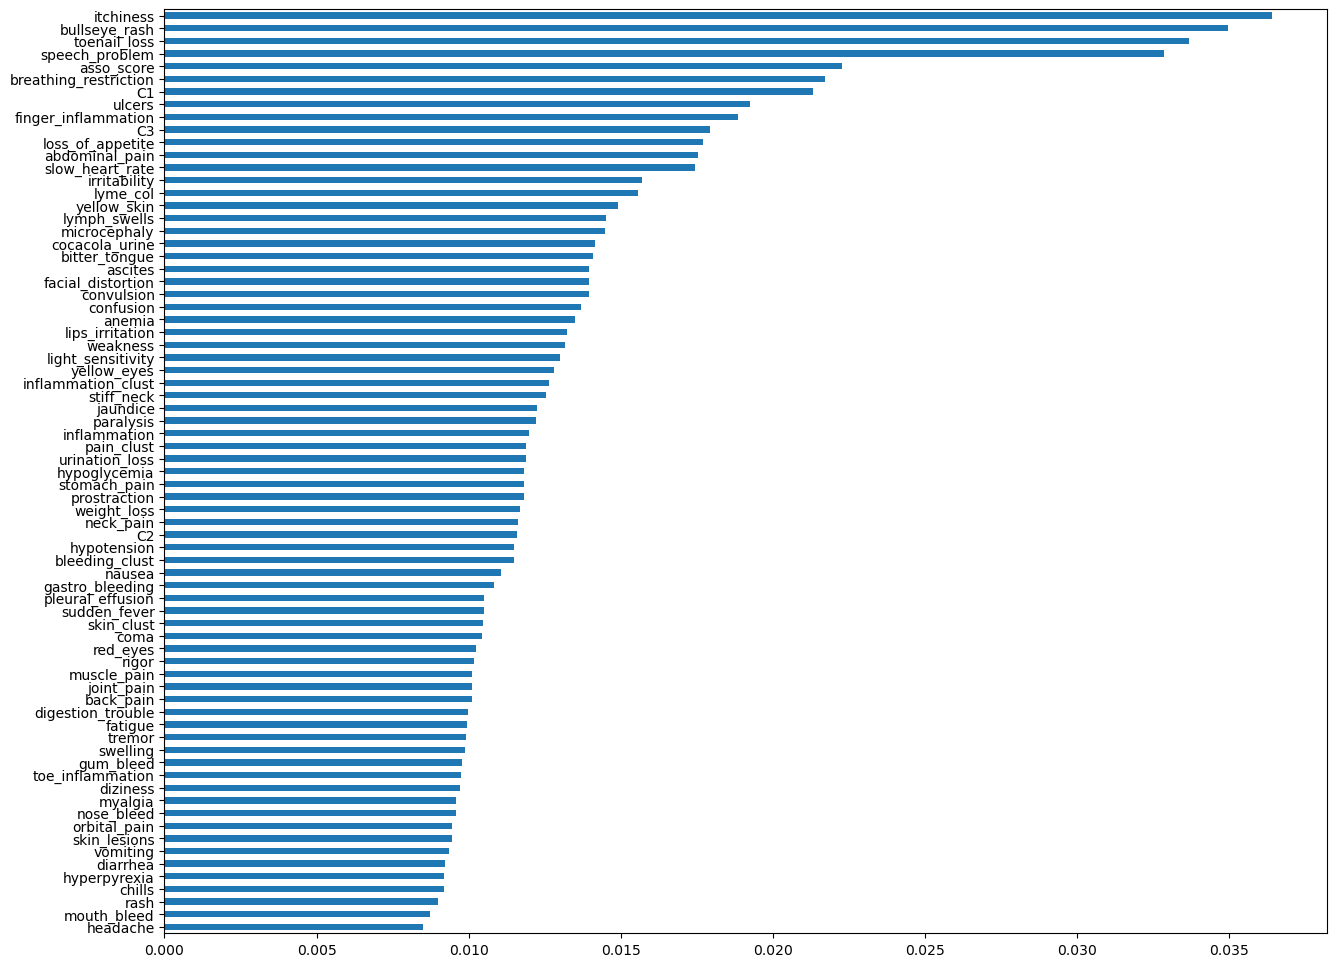

In [30]:
x_fe_im = xgb_model.feature_importances_
plot_feature_importance(x_fe_im)

In [31]:
def sub_fn(pred):
    top3 = np.argsort(-pred)[:,:3]
    hold = []
    for t in top3:
        f_p = ''
        for p in t:
            f_p = f'{f_p}{le.inverse_transform(np.array([p]))[0]} '
        hold.append(f_p)
    return hold

In [32]:
pred = xgb_model.predict_proba(test_df_aug.drop(columns = 'id'))
pred = sub_fn(pred)

In [33]:
sub = pd.read_csv('../input/playground-series-s3e13/sample_submission.csv')
sub['prognosis'] = pred

In [34]:
sub.to_csv('submission.csv', index = False)